## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170508288/170498071 [==============================] - 75s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape

(32, 32, 3)

[9]


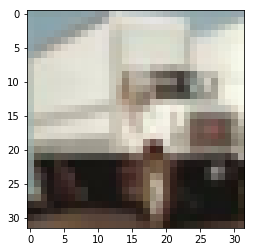

In [4]:
## Let's look at one of the images

print(y_train[444])
plt.imshow(x_train[444]);

In [5]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [7]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [8]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          25632     
_________________________________________________________________
activation_2 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

We still have 181K parameters, even though this is a "small" model.


In [9]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 43s 865us/step - loss: 1.7547 - acc: 0.3645 - val_loss: 1.4710 - val_acc: 0.4657
Epoch 2/15
50000/50000 [==============================] - 42s 831us/step - loss: 1.4766 - acc: 0.4686 - val_loss: 1.3168 - val_acc: 0.5329
Epoch 3/15
50000/50000 [==============================] - 49s 971us/step - loss: 1.3702 - acc: 0.5106 - val_loss: 1.2283 - val_acc: 0.5595
Epoch 4/15
50000/50000 [==============================] - 45s 891us/step - loss: 1.2996 - acc: 0.5373 - val_loss: 1.2340 - val_acc: 0.5656
Epoch 5/15
50000/50000 [==============================] - 38s 756us/step - loss: 1.2558 - acc: 0.5554 - val_loss: 1.2523 - val_acc: 0.5624
Epoch 6/15
50000/50000 [==============================] - 39s 777us/step - loss: 1.2239 - acc: 0.5643 - val_loss: 1.1650 - val_acc: 0.5877
Epoch 7/15
50000/50000 [==============================] - 41s 822us/step - loss: 1.1953 - acc: 0.5801 - val_loss: 1.

### Exercise
Our previous model had the structure:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. Build a more complicated model with the following pattern:
- Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

- Use strides of 1 for all convolutional layers.

2. How many parameters does your model have?  How does that compare to the previous model?

3. Train it for 5 epochs.  What do you notice about the training time, loss and accuracy numbers (on both the training and validation sets)?

5. Try different structures and run times, and see how accurate your model can be.


In [25]:
# Please provide your solution here
# Create model_2 as mentioned in the exercise

# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 5x5 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(5, 5)))
model_1.add(Dropout(0.25))

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

#max pool
model_1.add(MaxPooling2D(pool_size=(1, 1)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
activation_60 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 6, 6, 32)          25632     
_________________________________________________________________
activation_61 (Activation)   (None, 6, 6, 32)          0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 1, 1, 32)          25632     
__________

In [27]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 44s 878us/step - loss: 1.6721 - acc: 0.3645 - val_loss: 1.5982 - val_acc: 0.3948
Epoch 2/5
50000/50000 [==============================] - 40s 809us/step - loss: 1.6441 - acc: 0.3780 - val_loss: 1.5386 - val_acc: 0.4104
Epoch 3/5
50000/50000 [==============================] - 41s 811us/step - loss: 1.6221 - acc: 0.3885 - val_loss: 1.5192 - val_acc: 0.4193
Epoch 4/5
50000/50000 [==============================] - 38s 757us/step - loss: 1.5993 - acc: 0.3986 - val_loss: 1.5564 - val_acc: 0.4176
Epoch 5/5
50000/50000 [==============================] - 33s 665us/step - loss: 1.5793 - acc: 0.4079 - val_loss: 1.4896 - val_acc: 0.4417
